In [1]:
#Get features (stops words removed) by tokenizing corpus - no stemming in baseline
#Binary encoding
#Assign target group 
#Use mutual information to get final feature set

In [1]:
import os
import re
from pathlib import Path
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def importData():
    #Import Labelled Data
    DATA_DIR = "Data"
    thispath = Path().absolute()
    #dtype = {"index": str, "title": str, "description": str, "url": str, "date": str, "Retail Relevance": str, "Economy Relevant": str, "Market moving": str}
    RET_ARTICLES = os.path.join(DATA_DIR, "Labelled Articles.xlsx")
    
    df = pd.read_excel(RET_ARTICLES)

    try:
        df.head()
    except:
        pass
    return df

In [3]:
def assignStopWords(): 
    #Stop_words list Options
    #Variation 1: added stop words starting at 'one'
    stop_words = {'audio','i', 'me', 'us', 'my','myself','we','our','ours', 'ourselves','you', 'your', 'yours', 'yourself', 'yourselves','he',	 'him',	 'his',	 'himself',	 'she',	 'her',	 'hers',	 'herself',	 'it',	 'its',	 'itself',	 'they','them','their', 'theirs', 'themselves', 'what', 'which', 'who','whom', 'this', 'that', 'these', 'those',	 'am',	 'is',	 'are',	 'was',	 'were',	 'be',	 'been',	 'being',	 'have',	 'has',	 'had',	 'having',	 'do',	 'does',	 'did',	 'doing',	 'a',	 'an',	 'the',	 'and',	 'but',	 'if',	 'or',	 'because',	 'as',	 'until',	 'while',	 'of',	 'at',	 'by',	 'for',	 'with',	 'about',	 'into',	 'through',	 'during',	 'before',	 'after',	 'to',	 'from','up','down','in','out','on','off','over',	 'under',	 'again',	 'further',	 'then',	 'once',	 'here',	 'there',	 'when',	 'where',	 'why',	 'how',	 'all',	 'any',	 'both',	 'each',	 'few',	 'more',	 'most',	 'other',	 'some',	 'such',	 'no',	 'nor',	 'not',	 'only','own','same', 'so','than', 'too','very','s','t','can', 'will', 'just','don','should', 'now','one','two','twenty','three','thirty','four','forty','five','fifty','six','sixty','seven','seventy','eight','eighty','nine','ninety','ten','co','re','percent','make','example','would','18','says','put','includes','keep','already','continue','even','17','asked','enough','might','ve','8','amp','seems','ai','get','team','fox','side','give','tell','take','across','non','fact','0','looks','7','pace','monday','tuesday','wednesday','thursday','friday','saturday','use','30','11','read','programme','please','something','50','60','leave','using','car','musk', 'name','january','february','march','april','may','june','july','august','september','october','november','december'}

    #from nltk.corpus import stopwords
    #stop_words = set(stopwords.words('english'))
    #print(stop_words)
    return stop_words

In [4]:
def corpus_count_words(df, stop_words):
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for row in df.itertuples(index=True, name='Pandas'):
            attribute = str((row, 'content'))
            file_words = tokenizer.tokenize(attribute)
            #keep lowercased words that are not stop words as features
            file_wordsNS = [word.lower() for word in file_words if not word.lower() in stop_words]
            # remove words that are numbers
            file_wordsN = [word.lower() for word in file_wordsNS if not word.isnumeric()]
            #remove words with a word length less than 4 (i.e. 1-3)
            file_wordsF = [word.lower() for word in file_wordsN if not len(word)<4]
            word_counter.update(file_wordsF)
    return word_counter

In [5]:
# news_cnt = corpus_count_words(df1,stop_words)

In [6]:
# news_cnt.most_common(30)

In [7]:
#Binary encoding for features, also appends retail target group
def binary_encode_features(newsarticles, top_words):
    tokenizer = RegexpTokenizer(r'\w+')
    df_rows = []
    for row in tqdm(newsarticles.itertuples(index=True, name='Pandas')):
            attribute = str((row, 'content'))
            file_words = tokenizer.tokenize(attribute)
            df_rows.append([1 if word.lower() in file_words else 0 for word in top_words])      
    X = pd.DataFrame(df_rows, columns = top_words)
    
    return X

In [8]:
def mutualInformation(B_Encoding, y, top_words): 
    #Estimate mutual information for a discrete target variable.
    #Mutual information (MI) [1] between two random variables is a non-negative value, which measures the dependency between the variables.
    #It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
    featureVals= mutual_info_classif(B_Encoding, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    
    np.asarray(featureVals)

    Temp= pd.DataFrame(featureVals, columns = ['MI_Values'])
 
    Final = Temp.assign(target_group = top_words)
    
    Highest_Features = Final.nlargest(10000, 'MI_Values')
    
    return Highest_Features

In [9]:
def selectFeatures(**kwargs):
    df = importData()
    stop_words = assignStopWords()
    
    #Select subset of orig data
    df1 = df[['content','market moving']]    
    news_cnt = corpus_count_words(df1, stop_words)
    
    print("starting Binary Encoding")
    num_features = 10000
    top_words = [word for (word, freq) in news_cnt.most_common(num_features)]
    B_Encoding = binary_encode_features(df1, top_words)
    print(B_Encoding.head())
    y = df['market moving']
    B_Encoding.assign(target_group=y)
      
    print("Finished Bin Encoding. Collecting Highest Features")
    Highest_Features = mutualInformation(B_Encoding, y, top_words)
    Highest_Features = pd.DataFrame(Highest_Features)
    
    # Save as csv file in DATACOLLECTION data folder (bc it's needed for encoding script)
    if ('csv' in kwargs) and (kwargs['csv']):
        
        # File path for this file
        file_name = 'retailFeatureSet-MI.csv'
        thispath = Path().absolute()
        OUTPUT_DIR = os.path.join(thispath, "Data", file_name)
        
        # if the following line throws an error, use the line after to save in same folder
        pd.DataFrame.to_csv(Highest_Features, path_or_buf=OUTPUT_DIR)
        #pd.DataFrame.to_csv(Highest_Features, path_or_buf=file_name)
    
    print(Highest_Features)
    return Highest_Features

In [10]:
def main():
    HF = selectFeatures(csv = True)
    return HF

In [11]:
Highest_Features = main()

starting Binary Encoding


3148it [08:59,  5.84it/s]


   said  content  company  amazon  year  also  companies  market  index  like  \
0     1        1        1       0     1     1          0       0      0     0   
1     0        1        1       0     1     1          1       0      0     1   
2     1        1        1       0     1     0          0       0      0     0   
3     0        1        0       0     1     1          0       0      0     1   
4     1        1        0       0     0     0          1       0      0     0   

     ...     hess  gigantic  villain  startling  tuned  decisive  whirlpool  \
0    ...        0         0        0          0      0         0          0   
1    ...        0         0        0          0      0         0          0   
2    ...        0         0        0          0      0         0          0   
3    ...        0         0        0          0      0         0          0   
4    ...        0         0        0          0      0         0          0   

   honeywell  criticize  factions  
0 

In [17]:
#print(pd.DataFrame(Highest_Features['target_group']))

In [18]:
featureSet = pd.DataFrame(Highest_Features['target_group'])
    
# Save as csv file in DATACOLLECTION data folder (bc it's needed for encoding script)


# File path for this file
file_name = 'retailFeatureSet.csv'
thispath = Path().absolute()
OUTPUT_DIR = os.path.join(thispath, "Data", file_name)

# if the following line throws an error, use the line after to save in same folder
pd.DataFrame.to_csv(featureSet, path_or_buf=OUTPUT_DIR)

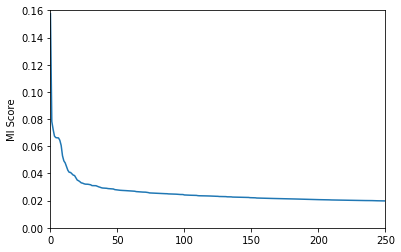

In [19]:
import matplotlib.pyplot as plt
plt.plot(Highest_Features['MI_Values'].values)
plt.ylabel('MI Score')
plt.axis([0, 250, 0, 0.16])
plt.show()

In [15]:
Highest_Features['MI_Values'].values

array([0.15685016, 0.08263148, 0.08260702, 0.07286888, 0.0727404 ,
       0.0654984 , 0.06318497, 0.05706316, 0.05342845, 0.05229887,
       0.04736192, 0.04527032, 0.03910597, 0.0382909 , 0.03785268,
       0.03732769, 0.03720455, 0.03714783, 0.0370412 , 0.03674766,
       0.03660287, 0.0365798 , 0.03439267, 0.03418774, 0.03344898,
       0.0327996 , 0.03204193, 0.03201651, 0.03143229, 0.0311371 ,
       0.03046653, 0.02992761, 0.02967316, 0.02956049, 0.02928386,
       0.02852677, 0.0283682 , 0.02813763, 0.02805806, 0.02797806,
       0.0274677 , 0.02681647, 0.02657687, 0.02647535, 0.02632202,
       0.02631743, 0.02626254, 0.02589552, 0.02561664, 0.02521897,
       0.02488037, 0.02471711, 0.02451793, 0.0243018 , 0.02428727,
       0.02358891, 0.02354837, 0.02335415, 0.02304278, 0.0228199 ,
       0.02278789, 0.02273341, 0.02271051, 0.02265611, 0.0225839 ,
       0.02241316, 0.02238736, 0.02237391, 0.02223753, 0.02202336,
       0.02195768, 0.02182063, 0.02170697, 0.02108735, 0.02104

In [12]:
Highest_Features

,MI_Values,target_group
8,0.159686,target
13,0.077075,stores
44,0.076992,inflation
28,0.073780,store
171,0.073689,child
26,0.073004,bank
37,0.071416,retailer
92,0.066799,central
389,0.064056,monetary
15,0.059455,online
